In [1]:
import numpy as np
import scipy as sp

def model(y, t, k1, k2, k3, epoRA):
    x1, x2, x3, x4 = y

    dx1 = - k1 * x1 * epoRA
    dx2 = - k2 * x2**2 + k1 * x1 * epoRA
    dx3 = - k3 * x3 + 0.5 * k2 * x2**2
    dx4 = k3 * x3

    return [dx1, dx2, dx3, dx4]



In [10]:
import pyabc
import numpy as np
import pypesto
import logging
%matplotlib inline

# for debugging
df_logger = logging.getLogger('Distance')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Acceptor')
df_logger.setLevel(logging.DEBUG)
df_logger = logging.getLogger('Epsilon')
df_logger.setLevel(logging.DEBUG)

importer = pypesto.PetabImporter.from_folder("/home/yannik/benchmark-models/hackathon_contributions_new_data_format/Boehm_JProteomeRes2014")
problem = importer.petab_problem
objective = importer.create_objective()

#print(problem.get_dynamic_simulation_parameters())
print(problem.get_optimization_parameters())
#df = problem.measurement_df
#print(df)
#print(df[['observableId', 'time', 'measurement']])
#print(objective(problem.x_nominal, return_dict=True)['rdatas'][0]['y'])

problem.parameter_df

INFO:pypesto.objective.petab_import:Using existing amici model in folder /home/yannik/Documents/Project8_pyABC_Noise/Study-ABC-Noise/study_abc_noise/jakstat/amici_models/Boehm_JProteomeRes2014.


['Epo_degradation_BaF3', 'k_exp_hetero', 'k_exp_homo', 'k_imp_hetero', 'k_imp_homo', 'k_phos', 'ratio', 'sd_pSTAT5A_rel', 'sd_pSTAT5B_rel', 'sd_rSTAT5A_rel', 'specC17']


,parameterName,parameterScale,lowerBound,upperBound,nominalValue,estimate,priorType,priorParameters,hierarchicalOptimization (optional)
parameterId,,,,,,,,,
Epo_degradation_BaF3,"EPO_{degradation,BaF3}",log10,-5,5,-1.568918,1,NaN,NaN,NaN
k_exp_hetero,"k_{exp,hetero}",log10,-5,5,-4.999705,1,NaN,NaN,NaN
k_exp_homo,"k_{exp,homo}",log10,-5,5,-2.209699,1,NaN,NaN,NaN
k_imp_hetero,"k_{imp,hetero}",log10,-5,5,-1.786007,1,NaN,NaN,NaN
k_imp_homo,"k_{imp,homo}",log10,-5,5,4.990114,1,NaN,NaN,NaN
k_phos,k_{phos},log10,-5,5,4.197735,1,NaN,NaN,NaN
ratio,ratio,lin,-5,5,0.693000,0,NaN,NaN,NaN
sd_pSTAT5A_rel,"\sigma_{pSTAT5A,rel}",log10,-5,5,0.585755,1,NaN,NaN,NaN
sd_pSTAT5B_rel,"\sigma_{pSTAT5B,rel}",log10,-5,5,0.818983,1,NaN,NaN,NaN


In [31]:
# data

mdf = problem.measurement_df
data = {}
keys = ['pSTAT5A_rel', 'pSTAT5B_rel', 'rSTAT5A_rel']
for key in keys:
    data[key] = np.array(mdf[mdf['observableId'] == key]['measurement'])
parameters = problem.get_optimization_parameters()
refval = {}
for p in parameters:
    refval[p] = float(pdf[pdf['parameterId'] == p]['nominalValue'])

def model(p):
    if isinstance(p, (np.ndarray, list)):
        p_vector = p
    else:
        p_vector = np.zeros(len(parameters))
        for ip, p_id in enumerate(parameters):
            p_vector[ip] = p[p_id]

    rdatas =  objective(p_vector, return_dict=True)['rdatas']
    y = rdatas[0]['y']

    y_pSTAT5A_rel = np.array(y[:, 0])
    y_pSTAT5B_rel = np.array(y[:, 1])
    y_rSTAT5A_rel = np.array(y[:, 2])
    return {'pSTAT5A_rel': y_pSTAT5A_rel,
            'pSTAT5B_rel': y_pSTAT5B_rel,
            'rSTAT5A_rel': y_rSTAT5A_rel}

def get_var(p):
    sd_pSTAT5A_rel = p['sd_pSTAT5A_rel']
    sd_pSTAT5B_rel = p['sd_pSTAT5B_rel']
    sd_rSTAT5A_rel = p['sd_rSTAT5A_rel']
    var = []
    for key in keys:
        var.extend([(10**p[f'sd_{key}'])**2] * len(data[key]))
    return np.array(var)

# prior
pdf = problem.parameter_df.reset_index()
limits = {}
for p in parameters:
    row = pdf[pdf['parameterId'] == p]
    limits[p] = (float(row['lowerBound']), float(row['upperBound']))
prior = pyabc.Distribution(**{p: pyabc.RV('uniform', a, b-a) for p, (a,b) in limits.items()})

# abc functions
distance = pyabc.IndependentNormalKernel(var=get_var, keys=keys)
acceptor = pyabc.StochasticAcceptor()
eps = pyabc.Temperature(schemes=[pyabc.AcceptanceRateScheme(), pyabc.ExpDecayFixedRatioScheme(alpha=0.75)])

In [32]:
type(problem.x_nominal)
print(model(problem.x_nominal))

{'pSTAT5A_rel': array([ 0.        , 75.15496737, 85.2163817 , 90.66947365, 92.14228421,
       92.50185256, 91.96289298, 90.62526325, 88.78583126, 86.52289751,
       80.80192848, 73.57729409, 65.10552602, 46.46230439, 29.51449062,
       17.1453491 ]), 'pSTAT5B_rel': array([ 0.        , 40.16546241, 54.50329774, 66.2879125 , 70.94299999,
       72.95899758, 73.59744119, 72.08299655, 69.43584116, 66.07208529,
       58.04599846, 49.22252953, 40.45409816, 25.29069931, 14.65840301,
        8.09321831]), 'rSTAT5A_rel': array([21.28928344, 34.82942051, 39.00902556, 42.23306022, 43.50055092,
       44.09441606, 44.45354651, 44.30198933, 43.88516419, 43.29898912,
       41.80544833, 40.08355068, 38.32345799, 35.24688599, 33.1841586 ,
       32.066869  ])}


In [ ]:
#sampler = pyabc.sampler.SingleCoreSampler()
abc = pyabc.ABCSMC(model, prior, distance, acceptor=acceptor, eps=eps, population_size=1000)
abc.new("sqlite:///h_boehm.db", data)
abc.run()

INFO:History:Start <ABCSMC(id=32, start_time=2019-11-25 09:36:06.178149, end_time=None)>
INFO:ABC:Calibration sample before t=0.
DEBUG:Acceptor:pdf_norm=-3.0281e+02 for t=0.
INFO:ABC:t: 0, eps: 15230187.455213506.
DEBUG:Acceptor:Encountered pd=-2.8749e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.9198e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.6734e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.7233e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.9691e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.6987e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.6751e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.7406e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.8060e+02 > c=-3.0281e+02, thus weight=1.0000e+00.
DEBUG:Acceptor:Encountered pd=-2.7877e+

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8cdc56dc88>,
      dtype=object)

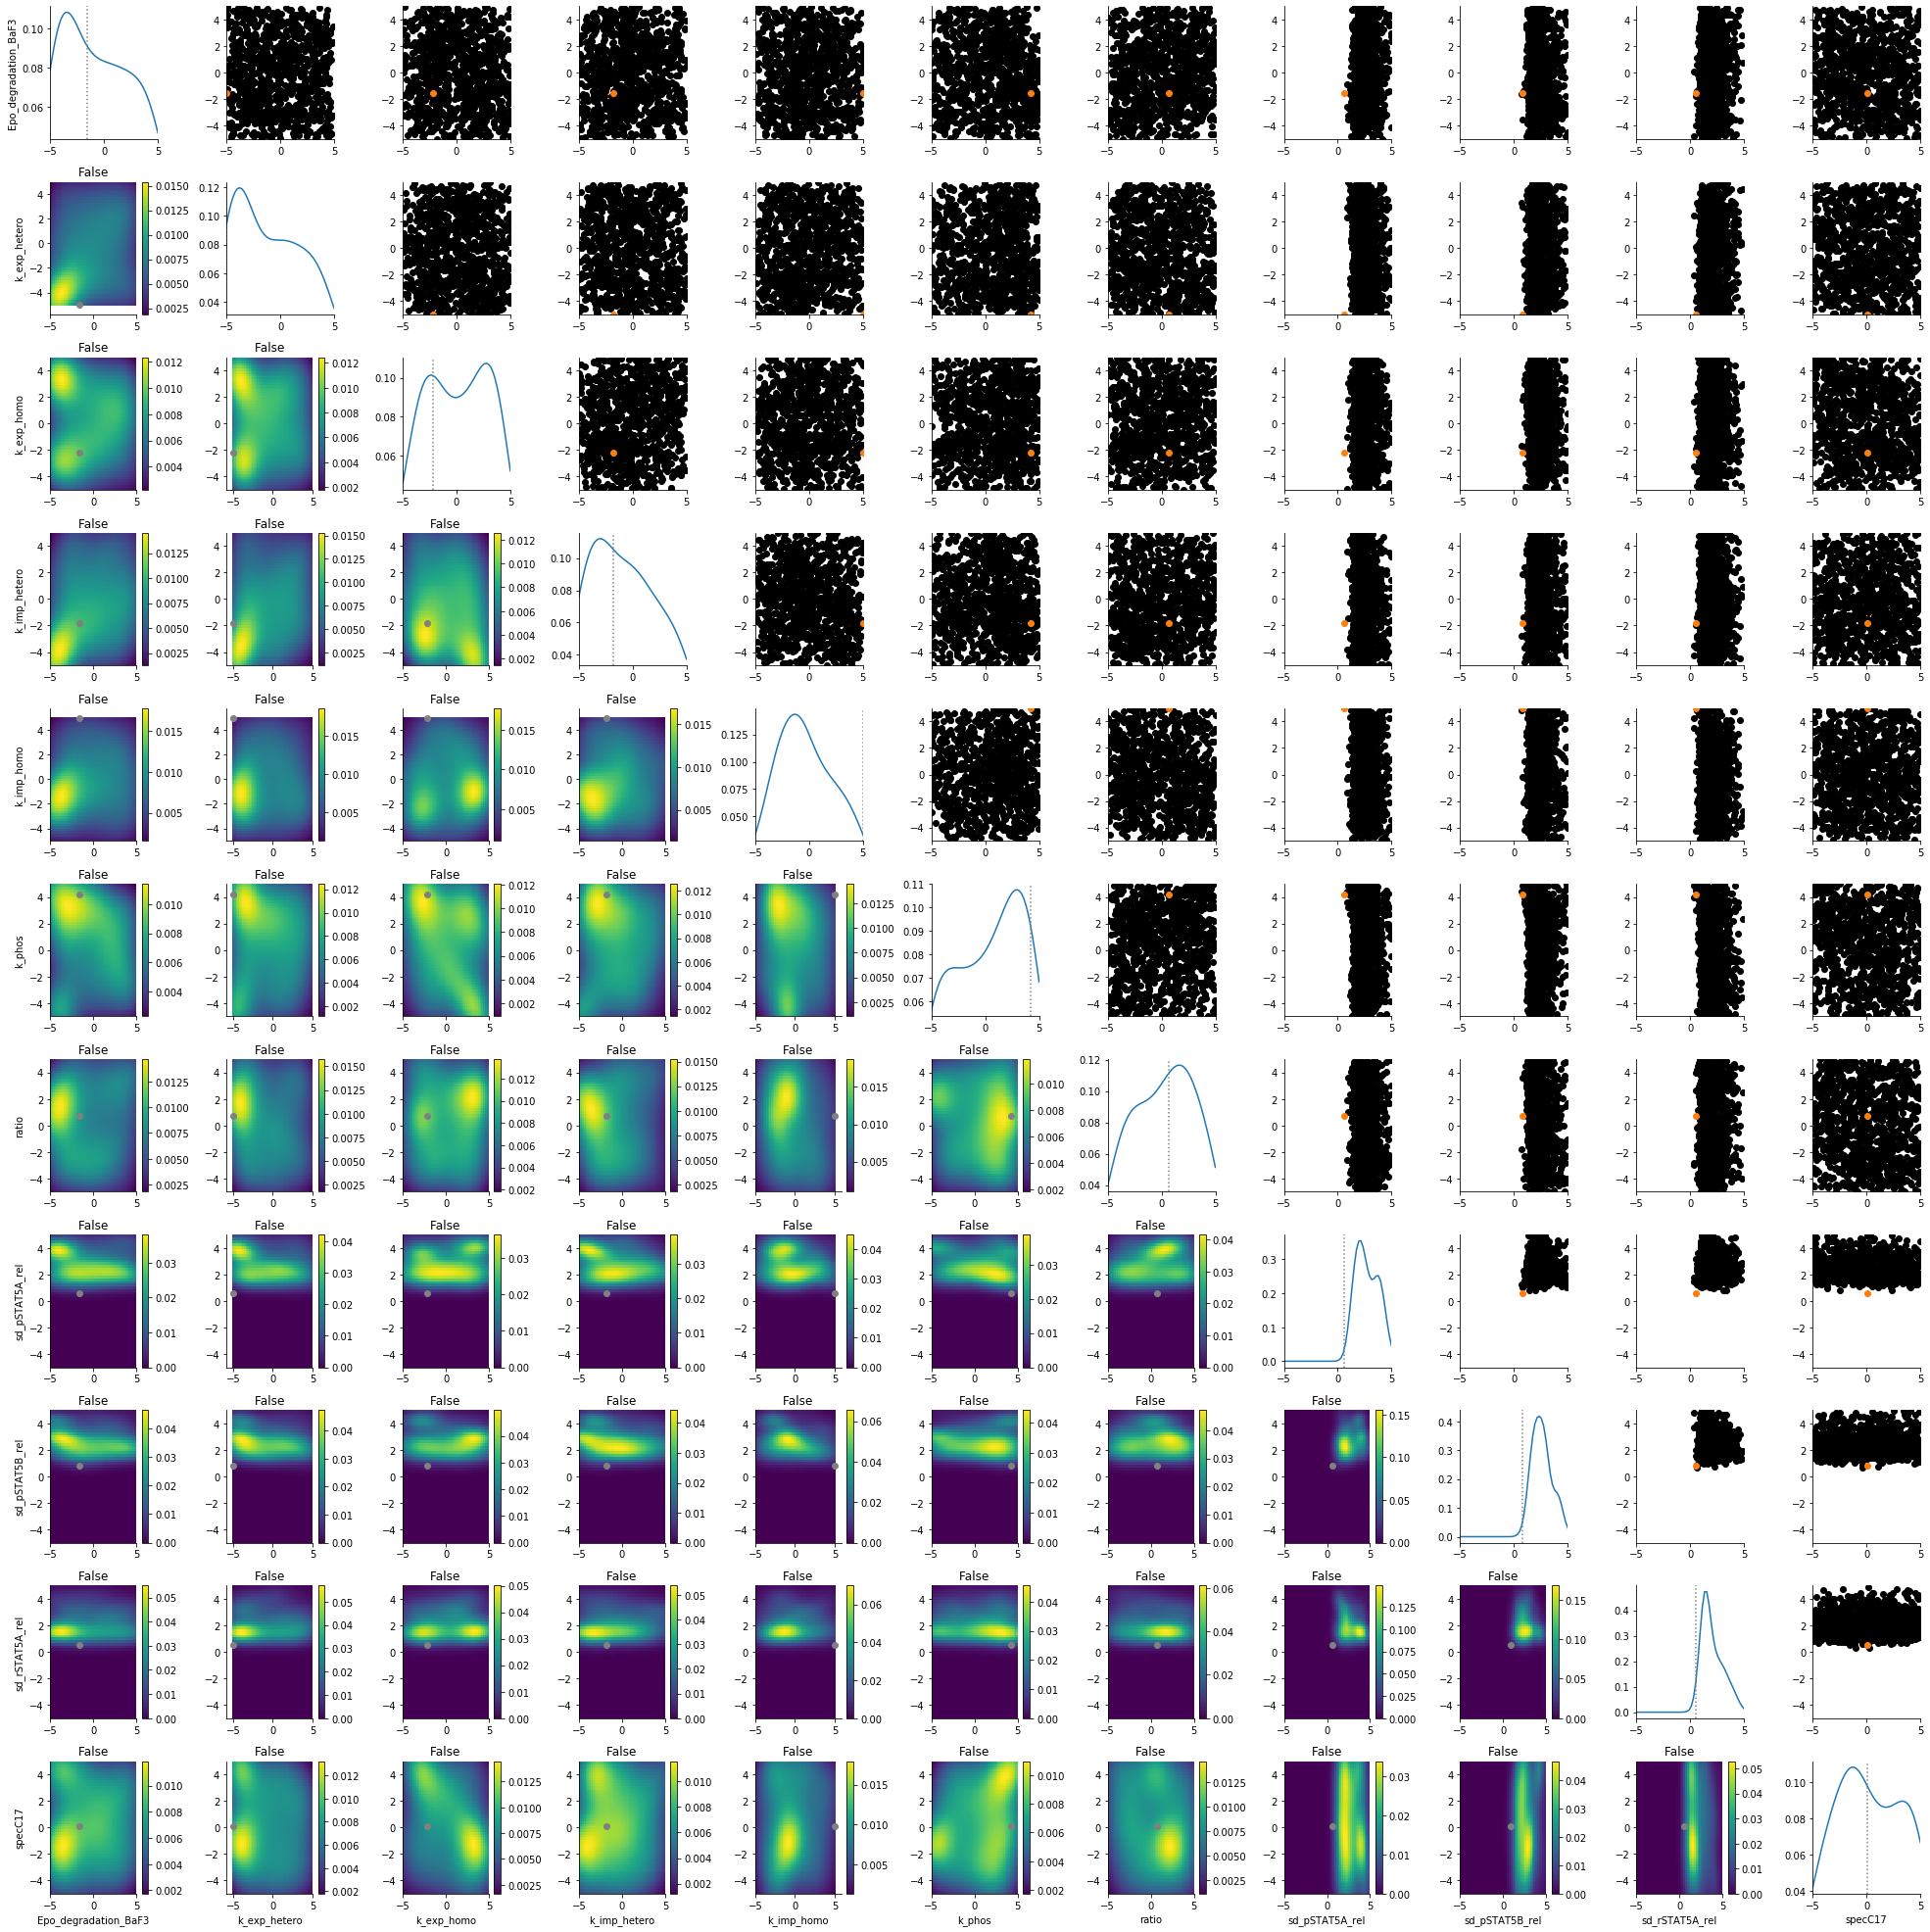

In [24]:
h = pyabc.History("sqlite:///h_boehm.db")
pyabc.visualization.plot_kde_matrix_highlevel(h, refval=refval, limits=limits)